In [122]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax import random
import numpy as np
class testClass:
    def __init__(self, N, dim):
        self._N = N
        self._dim = dim
        self.la = jax.numpy.linalg

    def log_wfi_dumb(self, r, params): # dumb because JW does not need to be (N, N), it can be (N*(N-1)//2, )
        epsilon = 1e-6  # Small epsilon value
        r_cpy = r.reshape(-1, self._N, self._dim)
        r_diff = r_cpy[:, None, :, :] - r_cpy[:, :, None, :]
        r_dist = self.la.norm(r_diff + epsilon, axis=-1)  # Add epsilon to avoid nan

        rij = jnp.triu(r_dist, k=1)

        x = jnp.einsum('nij,ij->n', rij, params['JW_dumb'])
        
        return x.squeeze(-1)
    
    def log_wfi_smart(self, r, params):
        epsilon = 1e-6  # Small epsilon value for stability
        r_cpy = r.reshape(-1, self._N, self._dim)
        r_diff = r_cpy[:, None, :, :] - r_cpy[:, :, None, :]
        r_dist = self.la.norm(r_diff + epsilon, axis=-1)  # Add epsilon to avoid nan
        
        rij = jnp.triu(r_dist, k=1)
        
        # Generate indices for the upper triangular matrix excluding diagonal
        triu_indices = jnp.triu_indices(self._N, k=1)
        k = triu_indices[0] * (self._N - 1) - triu_indices[0] * (triu_indices[0] + 1) // 2 + triu_indices[1] - triu_indices[0] - 1
        
        # Use these indices to select the corresponding elements from the JW_smart vector
        JW_smart = params['JW_smart'][k]
        
        # Perform the element-wise multiplication and sum
        x = jnp.einsum('nij,i->n', rij, JW_smart)
        
        return x.squeeze(-1)

    
    # jax grad
    def grad_log_wfi_dumb(self, r, params):
        return vmap(jax.grad(self.log_wfi_dumb, argnums=0), in_axes=(0, None))(r, params)


    def grad_log_wfi_smart(self, r, params):
        return vmap(jax.grad(self.log_wfi_smart, argnums=0), in_axes=(0, None))(r, params)
        
        
    
# initialize r with shape (nbatch, particles * dim)
nbatch = 1
N = 2
dim = 1
key = random.PRNGKey(1)
r = random.normal(key, (nbatch, N * dim))

print("r", r.reshape(-1, N, dim))
# initialize params

params_dumb = {'JW_dumb': random.normal(key, (N, N))}
params_smart = {'JW_smart': random.normal(key, (N * (N-1) // 2, ))}

# grad
# instantiate the class
your_class = testClass(N, dim)
your_class.log_wfi_dumb(r, params_dumb)

#print the forward pass
log_wfi = your_class.log_wfi_dumb(r, params_dumb)
print("jax log_wfi dumb", log_wfi, "with shape", log_wfi.shape)
log_wfi = your_class.log_wfi_smart(r, params_smart)
print("jax log_wfi smart", log_wfi, "with shape", log_wfi.shape)

grad_log_wfi = your_class.grad_log_wfi_dumb(r, params_dumb)
print("jax grad", grad_log_wfi, "with shape", grad_log_wfi.shape)



r [[[-0.11617039]
  [ 2.2125063 ]]]
jax log_wfi dumb -1.0731523 with shape ()
jax log_wfi smart -2.7578166 with shape ()
jax grad [[ 0.4608419 -0.4608419]] with shape (1, 2)


In [144]:
nbatch = 1
N = 2
dim = 1
r = np.random.randn(nbatch, N * dim)
#r = np.random.randn(N * dim,)
# mode 1
r_reshaped = r.reshape(-1, N, dim)
for i in range(N):
    # access particle i
    print("particle", i, r_reshaped[:, i, :])
print("=====")
# mode 2
# instead of reshaping, use strided access
for i in range(0, N*dim, dim):
    print("particle", i//dim, r[..., i:i+dim])

particle 0 [[0.25483576]]
particle 1 [[-0.71301476]]
=====
particle 0 [[0.25483576]]
particle 1 [[-0.71301476]]


In [46]:
import numpy.polynomial.hermite as P
def hermite(vals, deg, dim):
    """
    Compute the product of Hermite polynomials for the given values, degree, and dimension.

    Parameters:
    - vals: Array-like of values for which to compute the Hermite polynomial product.
    - deg: The degree of the Hermite polynomial.
    - dim: The dimension, indicating how many values and subsequent polynomials to consider.

    Returns:
    - The product of Hermite polynomials for the given inputs.
    """
    # Error handling for input parameters
    if not isinstance(vals, list) or not isinstance(deg, int) or not isinstance(dim, int):
        raise ValueError("Invalid input types for vals, deg, or dim.")
    if len(vals) != dim:
        raise ValueError("Dimension mismatch between 'vals' and 'dim'.")

    # Compute the product of Hermite polynomials across the given dimensions
    hermite_product = 1
    for val in vals:
        hermite_poly = P.Hermite([0] * deg + [1])(val)
        hermite_product *= hermite_poly

    return hermite_product

print(hermite([2, 2], 1, dim=2))


ValueError: Dimension mismatch between 'vals' and 'dim'.

In [4]:
def generate_degrees(nparticles, dim):
    max_comb = nparticles // 2
    combinations = [[0] * dim]
    seen = {tuple(combinations[0])}
    
    while len(combinations) < max_comb:
        new_combinations = []
        for comb in combinations:
            for i in range(dim):
                # Try incrementing each dimension by 1
                new_comb = comb.copy()
                new_comb[i] += 1
                new_comb_tuple = tuple(new_comb)
                if new_comb_tuple not in seen:
                    seen.add(new_comb_tuple)
                    new_combinations.append(new_comb)
                    if len(seen) == max_comb:
                        return np.array(combinations + new_combinations)
        combinations += new_combinations
    
    return np.array(combinations)
dim = 3
nparticles = 10
combinations_v2 = generate_degrees(nparticles, dim)
combinations_v2


array([[0, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [2, 0, 0]])

In [33]:
import jax.numpy as jnp
import jax
from numpy import polynomial as P
import numpy as np
nparticles = 10
dim = 2



def hermite(r, degs):
    """
    Compute the product of Hermite polynomials for the given values, degree, and dimension.

    Parameters:
    - vals: Array-like of values for which to compute the Hermite polynomial product. It should be of shape (nbatch, dim)
    - degs: The degrees of the Hermite polynomials.
    - dim: The dimension, indicating how many values and subsequent polynomials to consider.

    Returns:
    - The product of Hermite polynomials for the given inputs.

    #TODO: move this to a helper function
    """
    # Error handling for input parameters
    #if not isinstance(vals, list) or not isinstance(deg, int) or not isinstance(self._dim, int):
    #    raise ValueError("Invalid input types for vals, deg, or dim.")
    #if len(vals) != dim:
    #    raise ValueError("Dimension mismatch between 'vals' and 'dim'.")


    # Compute the product of Hermite polynomials across the given dimensions
    hermite_product = 1
    for batch in range(r.shape[0]):
        #cartesian of r[batch] and degs
        
        for i in range(len(degs)):
            deg = degs[i]
            r_ = r[batch][i]
            #print(f"print(P.Hermite([0] * {deg} + [1])({r_}))")
            hermite_poly = P.Hermite([0] * int(deg) + [1])(r_)
            hermite_product *= hermite_poly


    return hermite_product


def log_slater(r):
    """
    Decomposed spin Slater determinant in log domain.
    ln psi = ln det (D(up)) + ln det (D(down))
    In our ground state, half of the particles are spin up and half are spin down.
    We will also add the 1/sqrt(N!) normalization factor here.

    D = |phi_1(r_1) phi_2(r_1) ... phi_n(r_1)| 
        |phi_1(r_2) phi_2(r_2) ... phi_n(r_2)| 
        |   ...         ...          ...     | 
        |phi_1(r_n) phi_2(r_n) ... phi_n(r_n)| 

    where phi_i is the i-th single particle wavefunction, in our case it is a hermite polynomial.
    """
    A = nparticles // 2
    r = r.reshape(-1, nparticles, dim)
    r_up = r[:, : A, :]
    r_down = r[:, A :, :]
    slater_fact = np.log(np.sqrt(np.math.factorial(nparticles)))

    # Compute the Slater determinant for the spin up particles
    D_up = jnp.zeros((r.shape[0], A, A))
    D_down = jnp.zeros((r.shape[0], A, A))

    degree_combs = generate_degrees(nparticles, dim)

    for part in range(A):
        for j in range(A):
            degrees = degree_combs[j] 
            
            #print("====hermite", hermite(r_up[:, part, :], degrees))
            
            D_up = D_up.at[:, part, j].set(hermite(r_up[:, part, :], degrees))
            D_down = D_down.at[:, part, j].set(hermite(r_down[:, part, :], degrees))

    # Compute the Slater determinant for the spin down particles
    log_slater_up = jnp.linalg.slogdet(D_up)[0]
    log_slater_down = jnp.linalg.slogdet(D_down)[0]

    return log_slater_up + log_slater_down - 0.5 * slater_fact # we can precompute this. The minus sign is because we are computing the log of the inverse of the factorial


r = jnp.array(np.random.randn(1, nparticles * dim))
log_slater(r)

/var/folders/gg/pt9rjjws0_b60pgd3qk984140000gn/T/ipykernel_84528/3763078808.py:70: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  slater_fact = np.log(np.sqrt(np.math.factorial(nparticles)))


print(P.Hermite([0] * 0 + [1])(-0.4519834816455841))
print(P.Hermite([0] * 0 + [1])(-0.5464293956756592))
print(P.Hermite([0] * 0 + [1])(-0.35051533579826355))
print(P.Hermite([0] * 0 + [1])(0.44277459383010864))
print(P.Hermite([0] * 1 + [1])(-0.4519834816455841))
print(P.Hermite([0] * 0 + [1])(-0.5464293956756592))
print(P.Hermite([0] * 1 + [1])(-0.35051533579826355))
print(P.Hermite([0] * 0 + [1])(0.44277459383010864))
print(P.Hermite([0] * 0 + [1])(-0.4519834816455841))
print(P.Hermite([0] * 1 + [1])(-0.5464293956756592))
print(P.Hermite([0] * 0 + [1])(-0.35051533579826355))
print(P.Hermite([0] * 1 + [1])(0.44277459383010864))
print(P.Hermite([0] * 2 + [1])(-0.4519834816455841))
print(P.Hermite([0] * 0 + [1])(-0.5464293956756592))
print(P.Hermite([0] * 2 + [1])(-0.35051533579826355))
print(P.Hermite([0] * 0 + [1])(0.44277459383010864))
print(P.Hermite([0] * 1 + [1])(-0.4519834816455841))
print(P.Hermite([0] * 1 + [1])(-0.5464293956756592))
print(P.Hermite([0] * 1 + [1])(-0.35051533

Array([-3.7761033], dtype=float32)

In [93]:
dim = 3
def det(r):
    det_r = jnp.linalg.det(r)
    return det_r

def log_det(r):
    log_det_r = jnp.linalg.slogdet(r)[1]
    return log_det_r

def wf(r):
    return jnp.exp(-jnp.linalg.norm(r)**2)

def log_wf(r):
    return -jnp.linalg.norm(r)**2

r = jnp.array(np.random.randn(dim, dim)) 

grad_det = jax.grad(det)(r)
grad_wf = jax.grad(wf)(r)


print("1/wf * grad_wf", grad_wf / wf(r))

print("grad ln ", jax.grad(log_wf)(r))

print("\n grad ln wf == 1/wf * grad_wf", (abs(jax.grad(log_wf)(r) - grad_wf / wf(r)) < 0.001).all())

print("\n  1/det * grad det", grad_det / det(r))

print("==== det", det(r))
print("grad ln det", jax.grad(log_det)(r))



print("\n grad ln det == 1/det * grad_det", (abs(jax.grad(log_det)(r) - grad_det / det(r)) < 0.001).all())


1/wf * grad_wf [[-2.0443762e-04  3.5990626e-04 -7.4185060e-05]
 [-1.9279356e-05 -5.8702957e-05  4.9267084e-05]
 [ 1.7390294e-04  5.0164206e-05 -2.6005344e-04]]
grad ln  [[-2.0443763e-04  3.5990626e-04 -7.4185060e-05]
 [-1.9279356e-05 -5.8702961e-05  4.9267088e-05]
 [ 1.7390294e-04  5.0164210e-05 -2.6005344e-04]]

 grad ln wf == 1/wf * grad_wf True

  1/det * grad det [[12654.426   3515.1284  9140.335 ]
 [88889.74   65342.605  72046.914 ]
 [13230.24   11376.392  18732.555 ]]
==== det 2.5276656e-13
grad ln det [[12654.425  3515.128  9140.333]
 [88889.734 65342.6   72046.91 ]
 [13230.239 11376.391 18732.553]]

 grad ln det == 1/det * grad_det False


In [98]:
nparticles = 6
dim = 2

pade_aij = jnp.zeros((nparticles, nparticles))
for i in range(nparticles):
    for j in range(i+1, nparticles):
        # first N//2 particles are spin up, the rest are spin down
        # there is a more efficient way to do this for sure
        if i < nparticles // 2 and j < nparticles // 2:
            pade_aij = pade_aij.at[i, j].set(1 / (dim + 1))
        elif i >= nparticles // 2 and j >= nparticles // 2:
            pade_aij = pade_aij.at[i, j].set(1 / (dim + 1))
        else: 
            pade_aij = pade_aij.at[i, j].set(1 / (dim - 1))

In [99]:
pade_aij

Array([[0.        , 0.33333334, 0.33333334, 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.33333334, 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.33333334,
        0.33333334],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.33333334],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]], dtype=float32)

In [5]:
import numpy as np

A = np.random.randn(3, 3)
B = np.random.randn(3, 3)

# outer
C = np.outer(A, B).reshape(3,3,3,3,)

D = np.einsum('ij,kl->ijkl', A, B)



C - D < 1e-6

array([[[[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]]],


       [[[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]]],


       [[[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]]]])

In [1]:
import lapjax

    This script requires `tensorboard_plugin_profile` to be installed.


In [2]:
# import jax.numpy as jnp
# from jax import vmap
import lapjax.numpy as jnp
from lapjax import vmap
import jax 

import numpy as np
import time 
from functools import partial


def f(x, params):
    return params*x**2 

from lapjax import LapTuple, TupType

# input_x is the input of f(x)

#@partial(jax.jit)
def lap_of_f(x, params):
  input_x = LapTuple(x, is_input = True)
  output = f(input_x, params)
  return output.lap

def lap_of_f_hess(x, params):
  hessian_wf = vmap(jax.hessian(f), in_axes=(0, None))
  trace_hessian = vmap(jnp.trace)
  return trace_hessian(hessian_wf(x, params))



arr = np.random.randn(2000,100)
params = 1.0
start = time.time()
print(lap_of_f(arr, params))
print("lapjax time", time.time() - start)

arr = np.random.randn(2000,100)
start = time.time()
print(lap_of_f_hess(arr, params))
print("hess time", time.time() - start)



[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]
lapjax time 0.29260730743408203
[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]
hess time 14.127750873565674


In [11]:
# CASE2: a Slater-Determinants like wave functions
# In this case, we could leverage the derivative sparsity to
# achieve over a magnitude speed-up.

# construct input params
key = jax.random.PRNGKey(42)

n_elec = 16 # number of electrons
input_dim = 3 # the dimension of electron position
hidden_dim = 256
hidden_layer = 2
layer_dims = [input_dim,] + [hidden_dim,] * hidden_layer + [n_elec,]

def init_params(key):
    params = []
    left_dim = input_dim
    for right_dim in layer_dims:
        key, subkey = jax.random.split(key)
        params.append(jax.random.normal(subkey, (left_dim,right_dim)) * 0.1)
        left_dim = right_dim
    return params

# construct the wave functions. 
def slater_determinants(x, params):

    # x.shape = (n_elec * input_dim,)
    x = x.reshape(n_elec, input_dim)
    for param in params:
        # Each electron is processed by the same MLP function
        x = jnp.matmul(x, param)
        x = jnp.tanh(x)

    x = x + jnp.eye(x.shape[0])

    

    _, lnpsi = jnp.linalg.slogdet(x)
    return lnpsi

key, subkey = jax.random.split(key)
params_sd = init_params(key)

In [12]:
def get_kinetic_function_orig(func):
    def kinetic(data):
        grad = jax.grad(func)(data)
        print("grad", grad.shape)
        hess = jax.hessian(func)(data)
        return -0.5 * (jnp.trace(hess) + jnp.sum(grad ** 2))
        
    return kinetic

def get_kinetic_function_lapjax(func):
    from lapjax import LapTuple
    def kinetic(data):
        input_laptuple = LapTuple(data, is_input=True)
        output_laptuple = func(input_laptuple)
        grad = output_laptuple.grad
        print("grad", grad.shape)
        lap = output_laptuple.lap

        # A Laptupe stores both gradient and laplacian information,
        # so we do not need to compute gradient again.
        return -0.5 * lap - 0.5 * jnp.sum(grad**2)

    return kinetic

# get kinetic function
ke_original = get_kinetic_function_orig(lambda x: slater_determinants(x, params_sd))
ke_lapjax = get_kinetic_function_lapjax(lambda x: slater_determinants(x, params_sd))

vmap_ke_orignal = jax.jit(jax.vmap(ke_original))
vmap_ke_lapjax = jax.jit(jax.vmap(ke_lapjax))

In [13]:
# CASE2: precision test
batch_size = 128

key, subkey = jax.random.split(key)
data = jax.random.normal(subkey,(batch_size, input_dim*n_elec))

orig_results = vmap_ke_orignal(data)
lapjax_results = vmap_ke_lapjax(data)

# the maxium difference is a standard float32 numerical error
print(jnp.max(jnp.abs(orig_results-lapjax_results)))

grad (48,)
grad (48,)
7.1525574e-07


In [15]:
import time
def compute_time(vfunc, key, batch_size, input_dim, iterations=100):
    key, subkey = jax.random.split(key)
    data_pool = jax.random.normal(subkey,(iterations*2, batch_size, input_dim))
    
    data_pool1, data_pool2 = jnp.split(data_pool, 2)

    # warm up to avoid the cache problem
    for data in data_pool1:
        val = vfunc(data)

    start_time = time.time()
    for data in data_pool2:
        val = vfunc(data)
    end_time = time.time()
    return val, end_time - start_time


val, duration = compute_time(vmap_ke_orignal, 
                             key, batch_size, input_dim * n_elec)
print('time of hessian-trace:', duration)

val, duration = compute_time(vmap_ke_lapjax, 
                             key, batch_size, input_dim * n_elec)
# forward laplacian is roughly 2 times faster than the original method
print('time of forward laplacian:', duration)

time of hessian-trace: 17.55272603034973
time of forward laplacian: 1.7136318683624268


In [19]:
from functools import partial

import jax
import jax.numpy as jnp
from jax.experimental import jet
# jet.fact = lambda n: jax.lax.prod(range(1, n + 1))

def f(ws, wo, x):
    for w in ws:
        x = jax.lax.exp(x @ w)
    return jnp.reshape(x @ wo, ())

@jax.jit
@partial(jax.vmap, in_axes=(None, None, 0))
def laplacian_1(ws, wo, x):
    fun = partial(f, ws, wo)
    @jax.vmap
    def hvv(v):
        return jet.jet(fun, (x,), ((v, jnp.zeros_like(x)),))[1][1]
    return jnp.sum(hvv(jnp.eye(x.shape[0], dtype=x.dtype)))

@jax.jit
@partial(jax.vmap, in_axes=(None, None, 0))
def laplacian_3(ws, wo, x):
    fun = partial(f, ws, wo)
    return jnp.trace(jax.hessian(fun)(x))

def timer(f):
    from time import time
    f() # compile
    t = time()
    for _ in range(3):
        f()
    print((time() - t) / 3)

d = 16
ws = [jnp.zeros((d, d)) for _ in range(5)]
wo = jnp.zeros((d, 1))
x = jnp.zeros((512, d))

timer(lambda : jax.block_until_ready(laplacian_1(ws, wo, x)))
timer(lambda : jax.block_until_ready(laplacian_3(ws, wo, x)))

0.0017466545104980469
0.0014252662658691406


In [31]:
import jax.numpy as jnp

positions = jnp.array([1,2,3])

# tst 1
batch_size = 3
container = [[positions] * batch_size]

#print("container_dim", container)

type(container[1])



IndexError: list index out of range

In [25]:
container

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]], dtype=int32)

## checking stuff

In [32]:
import jax.numpy as jnp
import numpy as np
import time 




x_np = np.random.randn(1000, 1000)
y_np = np.random.randn(1000, 1000)


def dot_and_stuff(x, y):
    return jnp.dot(x, y) + 100*x + 100*y


start = time.time()
dot_and_stuff(x_np, y_np)
    


Array([[  30.997993  , -101.03757   ,  203.5024    , ...,  137.86655   ,
          94.08075   ,  221.06895   ],
       [ 226.67355   ,  168.71967   ,   48.394302  , ..., -176.88821   ,
         -40.23911   ,  386.17163   ],
       [-177.22252   ,    6.9170856 , -192.93011   , ...,    0.93268967,
           6.961529  ,  121.673874  ],
       ...,
       [-239.57462   , -279.90347   ,    5.686722  , ...,  158.27287   ,
         137.40155   ,  -78.64044   ],
       [  69.14392   ,   27.83804   ,  -85.63251   , ...,   -4.4442024 ,
          27.685966  ,  -22.886019  ],
       [-111.65703   ,   51.84831   ,  -98.04352   , ...,   40.530052  ,
         276.60132   ,  -75.43979   ]], dtype=float32)

In [1]:
path = "/Users/haas/Desktop/working_folder/convolution_results_list1/normalised_convolved_image0.tiff"
# open with plt.imshow(np.load(path))

import numpy as np
import matplotlib.pyplot as plt
import os
import time


plt.imshow(np.load(path))


IsADirectoryError: [Errno 21] Is a directory: '/Users/haas/Desktop/working_folder/convolution_results_list1'

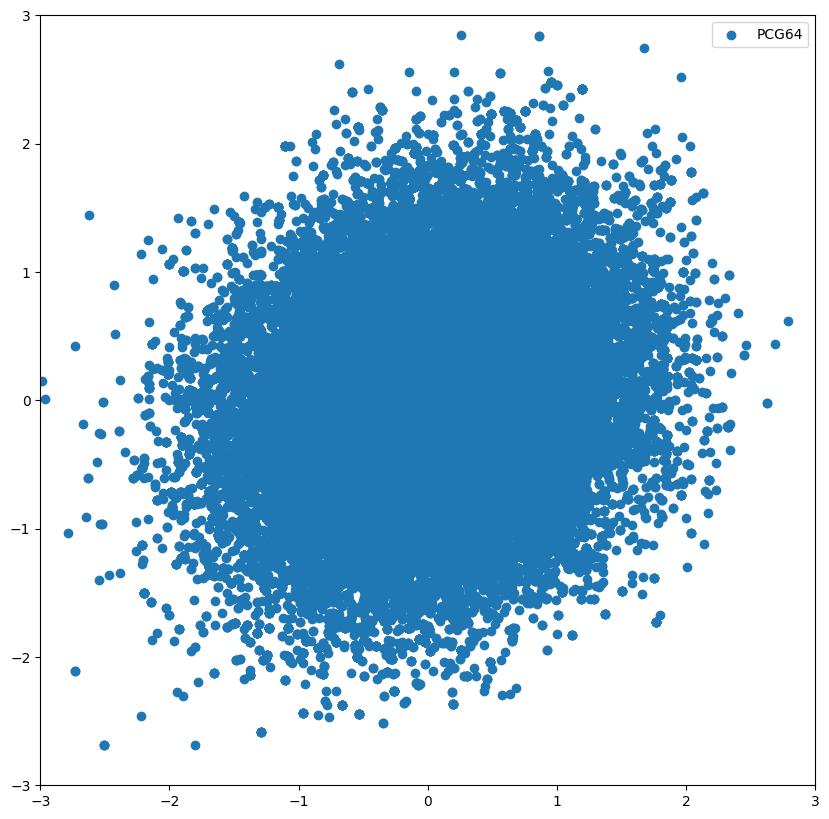

In [6]:
import numpy as np
import matplotlib.pyplot as plt

seed = 42
nsamples = 100000

def advance_state_philox(seed, delta):
    return np.random.Philox(seed).advance(delta)

def advance_state_pcg64(seed, delta):
    return np.random.PCG64(seed).advance(delta)

pcg_positions = np.random.randn(nsamples, 4)
philox_positions = np.random.randn(nsamples, 4)


def log_ansatz(x):
    return -0.5 * np.sum(x**2)

def logprob(x):
    return 2 * log_ansatz(x)

for i in range(nsamples):
    delta = i

    next_gen_phil = advance_state_philox(seed, delta)
    next_gen_pcg = advance_state_pcg64(seed, delta)

    rng_pcg = np.random.default_rng(next_gen_pcg)
    rng_phil = np.random.default_rng(next_gen_phil)
    # generate normal distribution of x and y
    
    prev_pos_pcg = pcg_positions[i-1]
    proposal_pcg = rng_pcg.normal(loc=prev_pos_pcg, scale=1)
    
    prev_pos_phil = philox_positions[i-1]
    proposal_phil = rng_phil.normal(loc=prev_pos_phil, scale=1)

    # acceptance ratio
    log_unif_pcg = np.log(rng_pcg.uniform())
    logprob_proposal_pcg = logprob(proposal_pcg)
    logprob_current_pcg = logprob(prev_pos_pcg)


    log_unif_phil = np.log(rng_phil.uniform())
    logprob_proposal_phil = logprob(proposal_phil)
    logprob_current_phil = logprob(prev_pos_phil)


    accept_pcg = log_unif_pcg < logprob_proposal_pcg - logprob_current_pcg
    accept_phil = log_unif_phil < logprob_proposal_phil - logprob_current_phil

    pcg_positions[i] = proposal_pcg if accept_pcg else prev_pos_pcg
    philox_positions[i] = proposal_phil if accept_phil else prev_pos_phil

    

plt.figure(figsize=(10, 10))

plt.scatter(pcg_positions[:, 0], pcg_positions[:, 1], label="PCG64")
plt.scatter(philox_positions[:, 0], philox_positions[:, 1], label="Philox")



plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.legend()
plt.show()






    
    

In [3]:
np.log(-0.1)

/var/folders/gg/pt9rjjws0_b60pgd3qk984140000gn/T/ipykernel_77771/2909127594.py:1: RuntimeWarning: invalid value encountered in log
  np.log(-0.1)


nan